In [1]:
import os
import numpy as np
import cv2                 
from random import shuffle
from tqdm import tqdm  
import tensorflow as tf 
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from collections import Counter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
TrianImage="/kaggle/input/chest-xray-pneumonia/chest_xray/train"
TestImage="/kaggle/input/chest-xray-pneumonia/chest_xray/test"
Normalimages = os.listdir(TrianImage + "/NORMAL")
Pneumonaimages = os.listdir(TrianImage + "/PNEUMONIA")

In [3]:
print(len(Normalimages), len(Pneumonaimages))
NUM_TRAINING_IMAGES = len(Normalimages) + len(Pneumonaimages) 
print(NUM_TRAINING_IMAGES)

1341 3875
5216


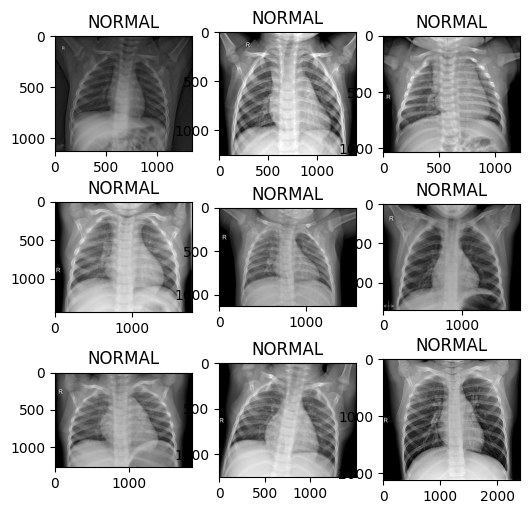

In [4]:
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")
plt.show()

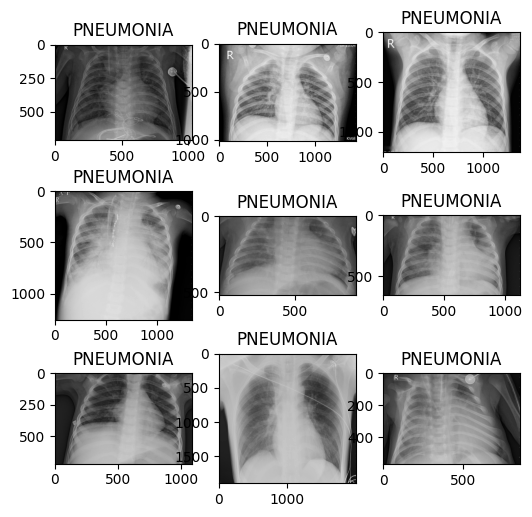

In [5]:
plt.figure(figsize=(6,6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrianImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
plt.show()

In [6]:
image_size = 224 
BATCH_SIZE = 16 
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   rotation_range=15,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train",
                                                 target_size = (image_size, image_size),
                                                 batch_size = BATCH_SIZE,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

testing_set = test_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/test",
                                            target_size = (image_size, image_size),
                                            batch_size = BATCH_SIZE,
                                            class_mode = 'categorical',
                                            shuffle = True)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [7]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence
print("train batch ", training_set.__getitem__(0)[0].shape)
print("test batch ", testing_set.__getitem__(0)[0].shape)
print("sample train label \n", training_set.__getitem__(0)[1][:5])

train batch  (16, 224, 224, 3)
test batch  (16, 224, 224, 3)
sample train label 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
print(training_set.class_indices)
print(testing_set.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}
{'NORMAL': 0, 'PNEUMONIA': 1}


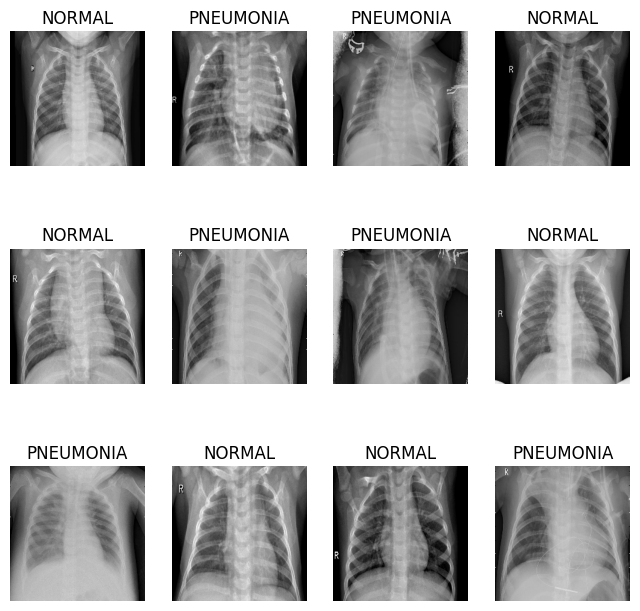

In [9]:
labels = ['NORMAL', 'PNEUMONIA']

sample_data = testing_set.__getitem__(1)[0] 
sample_label = testing_set.__getitem__(1)[1] 

plt.figure(figsize=(8,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    plt.imshow(sample_data[i])
    plt.title(labels[np.argmax(sample_label[i])])

# Models

In [10]:
!pip install efficientnet
import efficientnet.tfkeras as efn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.1 MB/s eta 0:00:00


In [12]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# gradcam

In [13]:
# https://keras.io/examples/vision/grad_cam/
from tensorflow import keras

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap, top_pred_index.numpy()

In [36]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [38]:
# https://keras.io/examples/vision/grad_cam/
def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # We use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # We create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

In [15]:
# label smoothing https://www.linkedin.com/pulse/label-smoothing-solving-overfitting-overconfidence-code-sobh-phd/
def categorical_smooth_loss(y_true, y_pred, label_smoothing=0.1):
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=label_smoothing)
    return loss

In [16]:
# training call backs 
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, epsilon=0.0001, patience=3, verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [17]:
# https://stackoverflow.com/questions/42586475/is-it-possible-to-automatically-infer-the-class-weight-from-flow-from-directory
counter = Counter(training_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 2.889634601043997, 1: 1.0}

In [18]:
# dfault input shapes 

print(tf.keras.applications.DenseNet201(weights='imagenet').input_shape)
print(efn.EfficientNetB7(weights='imagenet').input_shape) 
print(tf.keras.applications.VGG16(weights='imagenet').input_shape) 

82524592/82524592 [==============================] - 3s 0us/step
(None, 224, 224, 3)
268317848/268317848 [==============================] - 16s 0us/step
(None, 600, 600, 3)
553467096/553467096 [==============================] - 14s 0us/step
(None, 224, 224, 3)


# Pretrained densenet

In [21]:
pretrained_densenet = tf.keras.applications.DenseNet201(input_shape=(image_size, image_size, 3), weights='imagenet', include_top=False)

for layer in pretrained_densenet.layers:
  layer.trainable = False

x1 = pretrained_densenet.output
x1 = tf.keras.layers.AveragePooling2D(name="averagepooling2d_head")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_head")(x1)
x1 = tf.keras.layers.Dense(64, activation="relu", name="dense_head")(x1)
x1 = tf.keras.layers.Dropout(0.5, name="dropout_head")(x1)
model_out = tf.keras.layers.Dense(2, activation='softmax', name="predictions_head")(x1)

model_densenet = Model(inputs=pretrained_densenet.input, outputs=model_out)
model_densenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=categorical_smooth_loss,metrics=['accuracy'])
history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=10)   



/tmp/ipykernel_42/322056260.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_densenet = model_densenet.fit_generator(training_set, validation_data=testing_set, callbacks=[lr_reduce, es_callback], epochs=10)


Epoch 1/10
326/326 [==============================] - 116s 322ms/step - loss: 0.3862 - accuracy: 0.8940 - val_loss: 0.4419 - val_accuracy: 0.8189 - lr: 1.0000e-04
Epoch 2/10
326/326 [==============================] - 103s 316ms/step - loss: 0.3228 - accuracy: 0.9383 - val_loss: 0.3663 - val_accuracy: 0.8926 - lr: 1.0000e-04
Epoch 3/10
326/326 [==============================] - 104s 318ms/step - loss: 0.3070 - accuracy: 0.9456 - val_loss: 0.3570 - val_accuracy: 0.9022 - lr: 1.0000e-04
Epoch 4/10
326/326 [==============================] - 104s 319ms/step - loss: 0.3015 - accuracy: 0.9521 - val_loss: 0.3570 - val_accuracy: 0.9006 - lr: 1.0000e-04
Epoch 5/10
326/326 [==============================] - 103s 316ms/step - loss: 0.2960 - accuracy: 0.9571 - val_loss: 0.3829 - val_accuracy: 0.8830 - lr: 1.0000e-04
Epoch 6/10
326/326 [==============================] - ETA: 0s - loss: 0.2904 - accuracy: 0.9595
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
326/326 [====

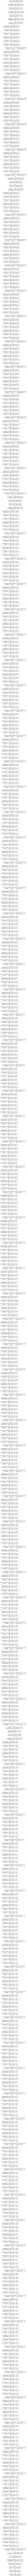

In [22]:
tf.keras.utils.plot_model(model_densenet, show_layer_names=True, show_shapes=True)

/tmp/ipykernel_42/4283597964.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


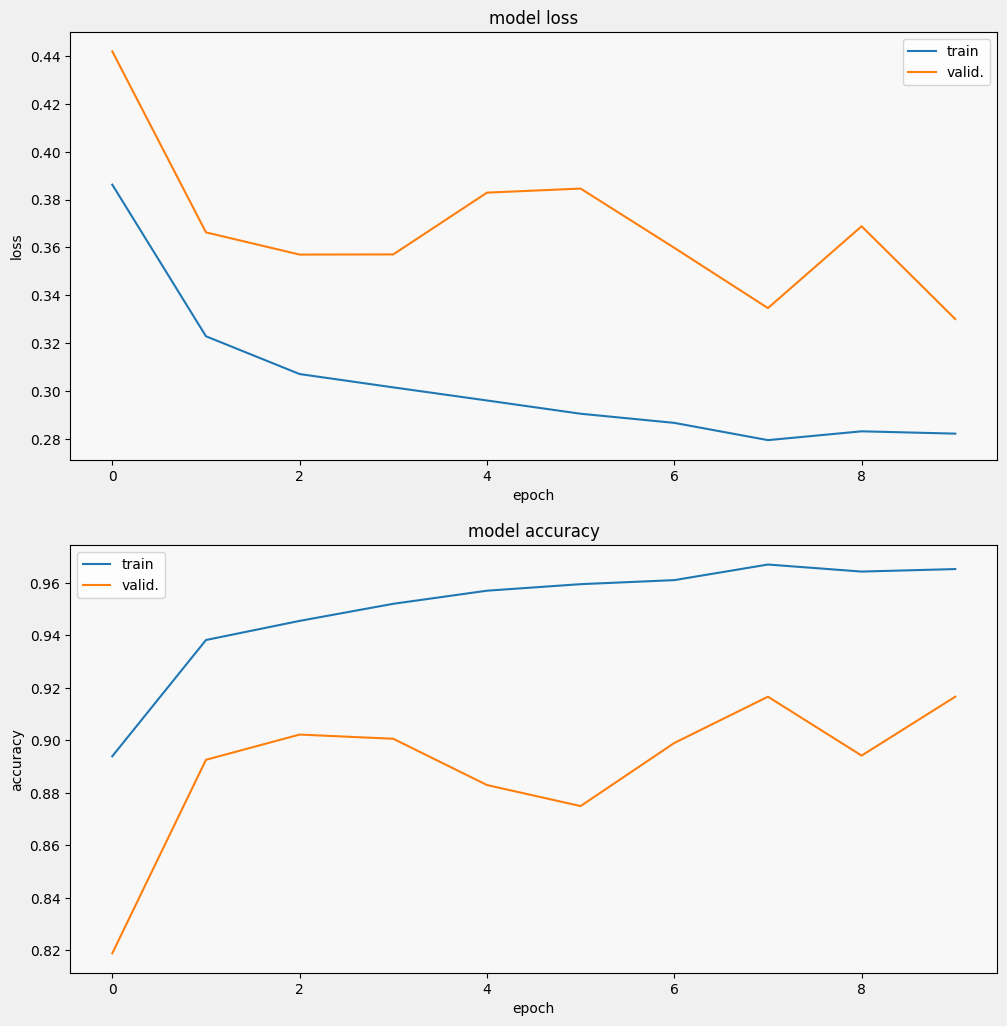

In [23]:
display_training_curves(history_densenet.history['loss'], history_densenet.history['val_loss'], 'loss', 211)
display_training_curves(history_densenet.history['accuracy'], history_densenet.history['val_accuracy'], 'accuracy', 212)


1/1 [==============================] - 3s 3s/step


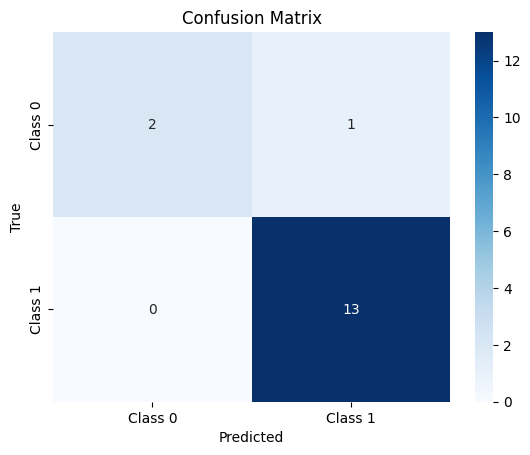

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_data, true_labels = next(testing_set)
predictions = model_densenet.predict(test_data)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
cm = confusion_matrix(true_labels.argmax(axis=1), binary_predictions.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [28]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

test_predictions= model_densenet.predict(test_data)

# Convert predictions to binary labels (0 or 1)
test_predictions_binary= (test_predictions > 0.5).astype(int)

#  F1 score ,recall,precision for test set
f1_test = f1_score(true_labels, test_predictions_binary,average='weighted')
precision = precision_score(true_labels, test_predictions_binary,average='weighted')
recall = recall_score(true_labels, test_predictions_binary,average='weighted')
accuracy = accuracy_score(true_labels, test_predictions_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score for Test Set: {f1_test:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

1/1 [==============================] - 0s 60ms/step
Accuracy: 0.9375
F1 Score for Test Set: 0.9324
Precision: 0.9420
Recall: 0.9375


In [29]:
last_conv_layer_name = "conv5_block32_concat"
classifier_layer_names = [
    "bn",
    "relu",
    "averagepooling2d_head",
    "flatten_head",
    "dense_head",
    "dropout_head",
    "predictions_head"
]

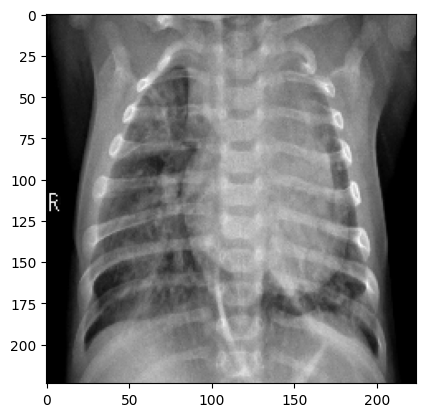

In [30]:
# test image
file_path =  '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [31]:
heatmap, top_index = make_gradcam_heatmap(test_image, model_densenet, last_conv_layer_name, classifier_layer_names)
print("predicted as", labels[top_index])

predicted as PNEUMONIA


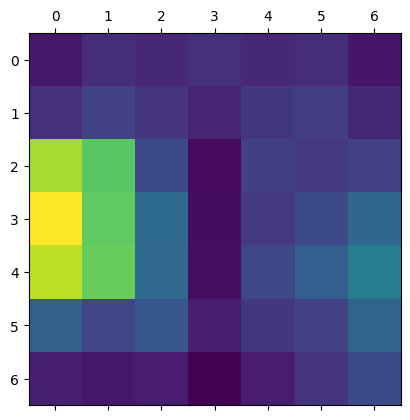

In [32]:
plt.matshow(heatmap)
plt.show()


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

def superimposed_img(image, heatmap):
    # We rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # We use jet colormap to colorize heatmap
    jet_colors = plt.cm.jet(np.arange(256))[:, :3]

    # We create an image with RGB colorized heatmap
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image_size, image_size))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * 0.4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


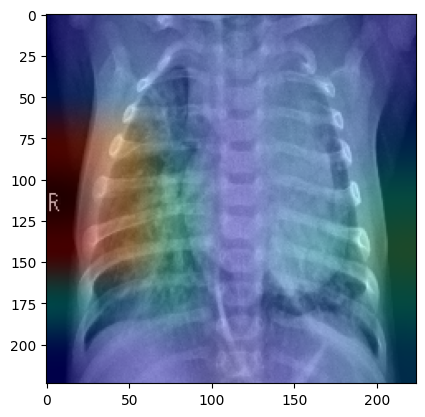

In [41]:
s_img = superimposed_img(test_image[0], heatmap)
plt.imshow(s_img)

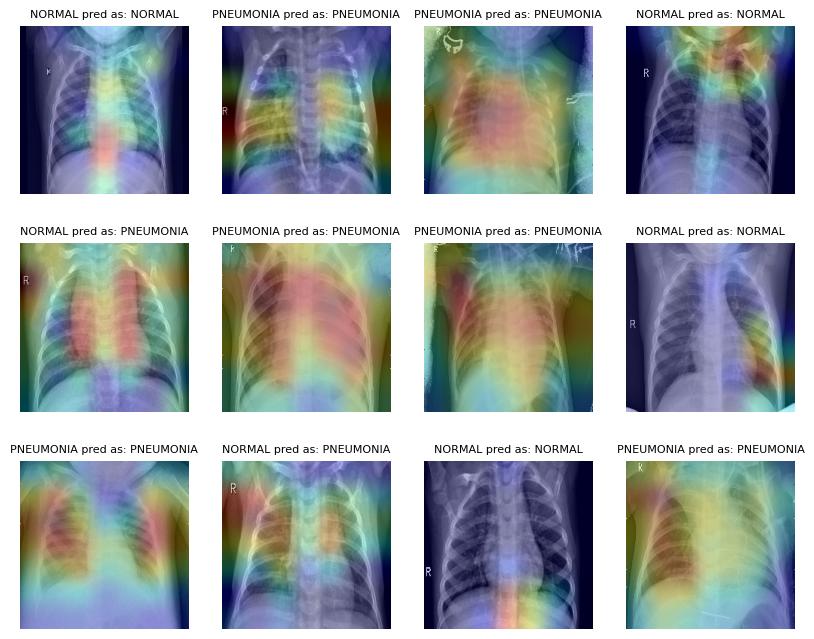

In [42]:

plt.figure(figsize=(10,8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.axis('off')
    heatmap, top_index = make_gradcam_heatmap(np.expand_dims(sample_data[i], axis=0), model_densenet, last_conv_layer_name, classifier_layer_names)
    img = np.uint8(255 * sample_data[i])
    s_img = superimposed_img(img, heatmap)
    plt.imshow(s_img)
    plt.title(labels[np.argmax(sample_label[i])] + " pred as: " + labels[top_index], fontsize=8)

# vgg16

In [30]:
from tensorflow import keras

# Replace 'your_custom_vgg16_model.h5' with the actual name of your model file
model_path = '/kaggle/input/model-vgg16res50/VGG-16-model3 (1).h5'

# Load the model
model = keras.models.load_model(model_path)

# Display model summary to identify the last convolutional layer
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [31]:
# Assuming your model is named 'model'
vgg16_base = model.get_layer('vgg16')

# Display the VGG16 base summary to identify the last convolutional layer
vgg16_base.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [50]:
# Print the names of layers in your model
for layer in model.layers:
    print(layer.name)


input_34
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
flatten
fc1
fc2
predictions


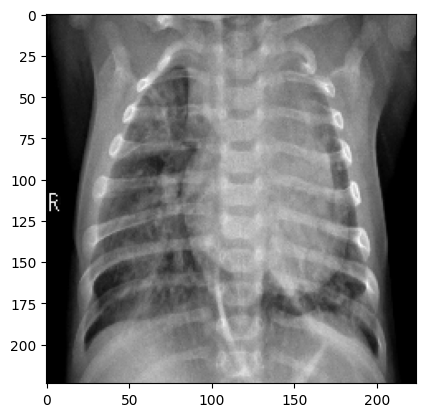

In [45]:
# test image
file_path =  '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
test_image = cv2.imread(file_path)
test_image = cv2.resize(test_image, (224,224),interpolation=cv2.INTER_NEAREST)
plt.imshow(test_image)
test_image = np.expand_dims(test_image,axis=0)

In [52]:
# Assuming your model is named 'model'
model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

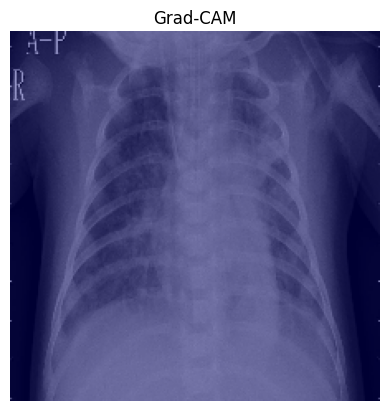

Superimposed Grad-CAM saved as 'superimposed_grad_cam.jpg'


In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the VGG16 model and remove the fully connected layers
model = VGG16(weights='imagenet')
model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('block5_conv3').output)

# Define a function for prediction and Grad-CAM computation
@tf.function
def compute_grad_cam(img_array):
    with tf.GradientTape() as tape:
        last_conv_layer_output = model(img_array)
        tape.watch(last_conv_layer_output)
        preds = model(img_array)

    # Extract numerical value of preds using tf.argmax
    class_index = tf.py_function(lambda x: tf.argmax(x).numpy(), [preds[0]], tf.int64)
    
    # Check if grads is not None
    grads = tape.gradient(preds[:, class_index], last_conv_layer_output)
    if grads is not None:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    else:
        pooled_grads = tf.constant(0.0, shape=last_conv_layer_output.shape[1:])

    return last_conv_layer_output[0], pooled_grads

# Load and preprocess the chest X-ray image
img_path ='/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg' 
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))  # Resize to match the model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Compute Grad-CAM
last_conv_layer_output, pooled_grads = compute_grad_cam(img_array)

# Generate Grad-CAM
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

# Resize heatmap to the original image size
heatmap = tf.image.resize(tf.expand_dims(heatmap, axis=-1), (img.shape[1], img.shape[0]))
heatmap = tf.squeeze(heatmap, axis=-1)

# Superimpose the heatmap on the original image
heatmap = tf.image.convert_image_dtype(heatmap, dtype=tf.uint8)
heatmap = cv2.applyColorMap(heatmap.numpy(), cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Save the superimposed image
cv2.imwrite('superimposed_grad_cam.jpg', superimposed_img)

# Display the superimposed image using matplotlib
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

print("Superimposed Grad-CAM saved as 'superimposed_grad_cam.jpg'")


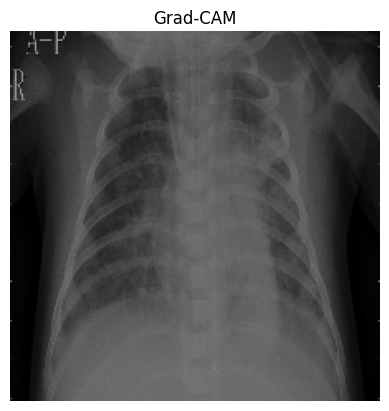

Superimposed Grad-CAM saved as 'superimposed_grad_cam.jpg'


In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the VGG16 model and remove the fully connected layers
model = VGG16(weights='imagenet')
model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('block5_conv3').output)

# Define a function for prediction and Grad-CAM computation
@tf.function
def compute_grad_cam(img_array):
    with tf.GradientTape() as tape:
        last_conv_layer_output = model(img_array)
        tape.watch(last_conv_layer_output)
        preds = model(img_array)

    # Extract numerical value of preds using tf.argmax
    class_index = tf.py_function(lambda x: tf.argmax(x).numpy(), [preds[0]], tf.int64)
    
    # Check if grads is not None
    grads = tape.gradient(preds[:, class_index], last_conv_layer_output)
    if grads is not None:
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    else:
        pooled_grads = tf.constant(0.0, shape=last_conv_layer_output.shape[1:])

    return last_conv_layer_output[0], pooled_grads

# Load and preprocess the chest X-ray image
img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg' 
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))  # Resize to match the model input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Compute Grad-CAM
last_conv_layer_output, pooled_grads = compute_grad_cam(img_array)

# Generate Grad-CAM
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
heatmap = tf.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)

# Resize heatmap to the original image size
heatmap_resized = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))

# Ensure valid values in heatmap_resized
heatmap_resized = np.nan_to_num(heatmap_resized)

# Normalize to the range [0, 255] for uint8
heatmap_resized_uint8 = (heatmap_resized * 255).astype(np.uint8)

# Superimpose the resized heatmap on the original image
superimposed_img = cv2.addWeighted(img, 0.6, cv2.cvtColor(heatmap_resized_uint8, cv2.COLOR_GRAY2BGR), 0.4, 0)

# Save the superimposed image
cv2.imwrite('superimposed_grad_cam.jpg', superimposed_img)

# Display the superimposed image using matplotlib
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.axis('off')
plt.show()

print("Superimposed Grad-CAM saved as 'superimposed_grad_cam.jpg'")


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np
import cv2
model = VGG16(weights='imagenet')
model.summary()

# Remove the fully connected layers
model = tf.keras.Model(inputs=model.input, outputs=model.get_layer('block5_conv3').output)


553467096/553467096 [==============================] - 19s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

# resnet50